## Environment setup

In [1]:
%%capture
!pip install --upgrade --no-deps nltk keras-hub

In [2]:
# import the necessary packages.
import os
import sys

# Tensorflow logs tons of warnings internally on import.
# An extreme solution is to redirect stderr.
stderr_fd = os.dup(2)
devnull = os.open(os.devnull, os.O_WRONLY)
os.dup2(devnull, 2)

import tensorflow as tf
from tensorflow.keras.layers import Dense, MultiHeadAttention, Embedding, Add, Dropout, LayerNormalization
from tensorflow.keras.optimizers import AdamW
import numpy as np
import pandas as pd
import bisect
import math
import re
import unicodedata
import nltk
import matplotlib.pyplot as plt
from keras_hub.metrics import Perplexity

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Initialize the TPU.
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [4]:
# Download the OAC research paper dataset.
!wget "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt"
!wget "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-valid.txt"
!mv "TinyStoriesV2-GPT4-train.txt" "train_sentences.txt"
!mv "TinyStoriesV2-GPT4-valid.txt" "valid_sentences.txt"

--2026-01-15 20:56:24--  https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt
Resolving huggingface.co (huggingface.co)... 13.226.251.81, 13.226.251.66, 13.226.251.112, ...
Connecting to huggingface.co (huggingface.co)|13.226.251.81|:443... 

connected.
HTTP request sent, awaiting response... 

302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/645e8da96320b0efe40ade7a/02e40cc51c59a4bc6c51bd7bc9acda4316e208745be060558eaf500cd14e9f96?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27TinyStoriesV2-GPT4-train.txt%3B+filename%3D%22TinyStoriesV2-GPT4-train.txt%22%3B&response-content-type=text%2Fplain&Expires=1768514184&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzY4NTE0MTg0fX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjQ1ZThkYTk2MzIwYjBlZmU0MGFkZTdhLzAyZTQwY2M1MWM1OWE0YmM2YzUxYmQ3YmM5YWNkYTQzMTZlMjA4NzQ1YmUwNjA1NThlYWY1MDBjZDE0ZTlmOTZcXD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSomcmVzcG9uc2UtY29udGVudC10eXBlPSoifV19&Signature=DyxCQsdps3bClh0shhImljS9mP97DXOGZxQKYwEUj9PRWQ08TMJSF38PmnFFC0FGiJB5VY%7EO4f11R%7E-er4O0SMtyK17IDgqM4YoQTvyh73mNboUvZHXS9%7EIn85NVHhXSKvd3%7EMsAqrwzo5UHJBuKQ6StNTkMKZMMTiwl2%7EnE-BmvXpUQeJmK9B27PL3MJLmGulxY-F-7mYrmND-E6uvw2lWHKBSmudGdvFjVwN5g1k%7Er9X9DhCCk98QzJ85os3f-HTZToee6

HTTP request sent, awaiting response... 

200 OK
Length: 2227753162 (2.1G) [text/plain]
Saving to: ‘TinyStoriesV2-GPT4-train.txt’

          TinyStori   0%[                    ]       0  --.-KB/s               

         TinyStorie   0%[                    ]       0  --.-KB/s               

        TinyStories   0%[                    ]   8.02M  6.97MB/s               

       TinyStoriesV   0%[                    ]   9.91M  7.32MB/s               

      TinyStoriesV2   1%[                    ]  37.54M  24.2MB/s               

     TinyStoriesV2-   3%[                    ]  63.95M  34.3MB/s               

    TinyStoriesV2-G   4%[                    ]  94.78M  45.9MB/s               

   TinyStoriesV2-GP   6%[>                   ] 127.89M  52.5MB/s               

  TinyStoriesV2-GPT   7%[>                   ] 148.97M  56.5MB/s               

 TinyStoriesV2-GPT4   8%[>                   ] 180.89M  63.8MB/s               

TinyStoriesV2-GPT4-   9%[>                   ] 195.59M  64.1MB/s    eta 30s    

inyStoriesV2-GPT4-t  10%[=>                  ] 219.53M  67.5MB/s    eta 30s    

nyStoriesV2-GPT4-tr  11%[=>                  ] 251.14M  72.7MB/s    eta 30s    

yStoriesV2-GPT4-tra  12%[=>                  ] 262.70M  71.9MB/s    eta 30s    

StoriesV2-GPT4-trai  13%[=>                  ] 283.00M  73.4MB/s    eta 30s    

toriesV2-GPT4-train  14%[=>                  ] 317.76M  78.4MB/s    eta 23s    

oriesV2-GPT4-train.  15%[==>                 ] 327.23M  75.8MB/s    eta 23s    

riesV2-GPT4-train.t  17%[==>                 ] 361.21M   105MB/s    eta 23s    

iesV2-GPT4-train.tx  18%[==>                 ] 383.59M   109MB/s    eta 23s    

esV2-GPT4-train.txt  19%[==>                 ] 413.82M   113MB/s    eta 23s    

sV2-GPT4-train.txt   21%[===>                ] 447.47M   118MB/s    eta 19s    

V2-GPT4-train.txt    22%[===>                ] 469.49M   116MB/s    eta 19s    

2-GPT4-train.txt     23%[===>                ] 490.42M   113MB/s    eta 19s    

-GPT4-train.txt      24%[===>                ] 511.47M   117MB/s    eta 19s    

GPT4-train.txt       24%[===>                ] 526.02M   113MB/s    eta 19s    

PT4-train.txt        26%[====>               ] 558.55M   114MB/s    eta 17s    

T4-train.txt         27%[====>               ] 587.69M   119MB/s    eta 17s    

4-train.txt          28%[====>               ] 610.58M   117MB/s    eta 17s    

-train.txt           30%[=====>              ] 639.39M   118MB/s    eta 17s    

train.txt            31%[=====>              ] 666.65M   124MB/s    eta 17s    

rain.txt             33%[=====>              ] 701.34M   125MB/s    eta 15s    

ain.txt              33%[=====>              ] 718.60M   126MB/s    eta 15s    

in.txt               35%[======>             ] 753.22M   131MB/s    eta 15s    

n.txt                36%[======>             ] 774.95M   126MB/s    eta 15s    

.txt                 37%[======>             ] 805.93M   130MB/s    eta 15s    

txt                  39%[======>             ] 831.29M   128MB/s    eta 13s    

xt                   40%[=======>            ] 853.08M   127MB/s    eta 13s    

t                    41%[=======>            ] 885.62M   128MB/s    eta 13s    

                     43%[=======>            ] 913.84M   130MB/s    eta 13s    

                  T  44%[=======>            ] 935.22M   135MB/s    eta 13s    

                 Ti  45%[========>           ] 963.03M   134MB/s    eta 11s    

                Tin  46%[========>           ] 994.95M   134MB/s    eta 11s    

               Tiny  48%[========>           ]   1024M   136MB/s    eta 11s    

              TinyS  49%[========>           ]   1.03G   135MB/s    eta 11s    

             TinySt  51%[=========>          ]   1.06G   138MB/s    eta 11s    

            TinySto  52%[=========>          ]   1.09G   139MB/s    eta 9s     

           TinyStor  54%[=========>          ]   1.12G   140MB/s    eta 9s     

          TinyStori  55%[==========>         ]   1.15G   141MB/s    eta 9s     

         TinyStorie  56%[==========>         ]   1.18G   144MB/s    eta 9s     

        TinyStories  57%[==========>         ]   1.20G   141MB/s    eta 9s     

       TinyStoriesV  59%[==========>         ]   1.23G   142MB/s    eta 8s     

      TinyStoriesV2  60%[===========>        ]   1.26G   143MB/s    eta 8s     

     TinyStoriesV2-  62%[===========>        ]   1.29G   145MB/s    eta 8s     

    TinyStoriesV2-G  63%[===========>        ]   1.32G   145MB/s    eta 8s     

   TinyStoriesV2-GP  64%[===========>        ]   1.34G   144MB/s    eta 8s     

  TinyStoriesV2-GPT  66%[============>       ]   1.38G   148MB/s    eta 6s     

 TinyStoriesV2-GPT4  67%[============>       ]   1.40G   147MB/s    eta 6s     

TinyStoriesV2-GPT4-  69%[============>       ]   1.43G   148MB/s    eta 6s     

inyStoriesV2-GPT4-t  70%[=============>      ]   1.45G   146MB/s    eta 6s     

nyStoriesV2-GPT4-tr  71%[=============>      ]   1.49G   146MB/s    eta 6s     

yStoriesV2-GPT4-tra  72%[=============>      ]   1.51G   144MB/s    eta 5s     

StoriesV2-GPT4-trai  74%[=============>      ]   1.54G   144MB/s    eta 5s     

toriesV2-GPT4-train  75%[==============>     ]   1.57G   142MB/s    eta 5s     

oriesV2-GPT4-train.  77%[==============>     ]   1.60G   144MB/s    eta 5s     

riesV2-GPT4-train.t  78%[==============>     ]   1.63G   142MB/s    eta 5s     

iesV2-GPT4-train.tx  79%[==============>     ]   1.66G   143MB/s    eta 4s     

esV2-GPT4-train.txt  81%[===============>    ]   1.69G   143MB/s    eta 4s     

sV2-GPT4-train.txt   82%[===============>    ]   1.71G   142MB/s    eta 4s     

V2-GPT4-train.txt    84%[===============>    ]   1.74G   143MB/s    eta 4s     

2-GPT4-train.txt     85%[================>   ]   1.77G   145MB/s    eta 4s     

-GPT4-train.txt      86%[================>   ]   1.80G   144MB/s    eta 2s     

GPT4-train.txt       88%[================>   ]   1.83G   144MB/s    eta 2s     

PT4-train.txt        89%[================>   ]   1.85G   142MB/s    eta 2s     

T4-train.txt         90%[=================>  ]   1.87G   136MB/s    eta 2s     

4-train.txt          91%[=================>  ]   1.90G   135MB/s    eta 2s     

-train.txt           93%[=================>  ]   1.94G   138MB/s    eta 1s     

train.txt            93%[=================>  ]   1.94G   126MB/s    eta 1s     

rain.txt             94%[=================>  ]   1.96G   122MB/s    eta 1s     

ain.txt              95%[==================> ]   1.99G   124MB/s    eta 1s     

in.txt               96%[==================> ]   2.00G   121MB/s    eta 1s     

n.txt                98%[==================> ]   2.03G   122MB/s    eta 0s     

.txt                 99%[==================> ]   2.06G   118MB/s    eta 0s     

TinyStoriesV2-GPT4- 100%[===================>]   2.07G   118MB/s    in 18s     

2026-01-15 20:56:42 (119 MB/s) - ‘TinyStoriesV2-GPT4-train.txt’ saved [2227753162/2227753162]



--2026-01-15 20:56:43--  https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-valid.txt
Resolving huggingface.co (huggingface.co)... 13.226.251.112, 13.226.251.20, 13.226.251.66, ...
Connecting to huggingface.co (huggingface.co)|13.226.251.112|:443... connected.


HTTP request sent, awaiting response... 

302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/645e8da96320b0efe40ade7a/e9c9ab082c52b89a2e85b03407638201d088148e94dccd9b127c60226e2a51bf?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27TinyStoriesV2-GPT4-valid.txt%3B+filename%3D%22TinyStoriesV2-GPT4-valid.txt%22%3B&response-content-type=text%2Fplain&Expires=1768514203&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzY4NTE0MjAzfX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjQ1ZThkYTk2MzIwYjBlZmU0MGFkZTdhL2U5YzlhYjA4MmM1MmI4OWEyZTg1YjAzNDA3NjM4MjAxZDA4ODE0OGU5NGRjY2Q5YjEyN2M2MDIyNmUyYTUxYmZcXD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSomcmVzcG9uc2UtY29udGVudC10eXBlPSoifV19&Signature=TXdeIT5snhE2m2X3jObOgpi9qhL8eE5Q-487WXkHVbIm6Hn3zSvPPa2K7ZctgEKBShsfuUswlSGty56UcGlQDBpWGlFKYY2CvhgF9Lhzz3TWuY2J8OmCTcXlMFihuFGf6XdZe9bMbwFl%7EKwmthBdb-ShEnbeNgPiSAZKWAtEWEv11lkh0VscL3K%7EgPV9NA4ZyjkAadC93JhSsbZfgW9TUcV4dxeosHzIlsa8UqPgN2z8Jpi2iB299RH2AuSsOelz8eqOVjgN4CzAV9SN

HTTP request sent, awaiting response... 

200 OK
Length: 22502601 (21M) [text/plain]
Saving to: ‘TinyStoriesV2-GPT4-valid.txt’

          TinyStori   0%[                    ]       0  --.-KB/s               

         TinyStorie   0%[                    ]   1.35K  1.63KB/s               

TinyStoriesV2-GPT4- 100%[===================>]  21.46M  21.4MB/s    in 1.0s    

2026-01-15 20:56:44 (21.4 MB/s) - ‘TinyStoriesV2-GPT4-valid.txt’ saved [22502601/22502601]



## Data loading and preparation
### Loading the entire file

In [5]:
# Loading the text data.
def read_file(filename, limit = None):
    with open(filename, "r") as f:
        # limit restricts dataset size (in bytes).
        dataset = f.readlines(limit)
    dataset = " ".join(dataset).split("<|endoftext|>")
    return dataset

# limit = 2**25 # 32MB of text.
train_file = "train_sentences.txt"
val_file = "valid_sentences.txt"
dataset = read_file(train_file)
val_set = read_file(val_file)
print(f"We have {len(dataset)} stories.")

We have 2717700 stories.


### Normalizing the text using regex.

In [6]:
# Pre-compiled patterns for reuse.
URL_RE = re.compile(r'\b(?:https?://|www\.)\S+\b', re.IGNORECASE)
EMAIL_RE = re.compile(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b')
PUNCT_RE = re.compile(r'([.,;:!?()\[\]{}=%<>"\'#~\-_|\&+\*/\\^@$`0-9])\1+')
PUNCT_SPACE_RE = re.compile(r'\s*([.,;:!?()\[\]{}=%<>"\'#~\-_|\&+\*/\\^@$`0-9])\s*')

def clean_text(text: str) -> str:
    # The increase in tokens from uppercase isn't worth it.
    text = text.lower()

    # Remove URLs
    text = URL_RE.sub('', text)

    # Remove email addresses
    text = EMAIL_RE.sub('',text)

    # Normalize accented latin characters to ASCII
    # é → e, ñ → n, ü → u, etc.
    text = unicodedata.normalize('NFKD', text)
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Add a space before and after punctuation if missing
    # Covers . , ; : ! ? ) ] } = % > < etc.
    text = PUNCT_RE.sub(r'\1',text)
    text = PUNCT_SPACE_RE.sub(r' \1 ',text)

    return text.strip()

In [7]:
# Preprocessing the entire set.
dataset = list(map(clean_text, dataset))
val_set = list(map(clean_text, val_set))
f"The first paragraph of data: {dataset[0]}"

"The first paragraph of data: once upon a time there was a little boy named ben . ben loved to explore the world around him . he saw many amazing things , like beautiful vases that were on display in a store . one day , ben was walking through the store when he came across a very special vase . when ben saw it he was amazed ! he said , wow , that is a really amazing vase ! can i buy it ? the shopkeeper smiled and said , of course you can . you can take it home and show all your friends how amazing it is ! so ben took the vase home and he was so proud of it ! he called his friends over and showed them the amazing vase . all his friends thought the vase was beautiful and couldn ' t believe how lucky ben was . and that ' s how ben found an amazing vase in the store !"

### Building the vocabulary dictionary.

In [8]:
vocab = sorted(set(" ".join(dataset).split()))
vocab_size = len(vocab)
print(f"Vocabulary has {vocab_size} possible tokens excluding the special ones.")

Vocabulary has 38783 possible tokens excluding the special ones.


In [9]:
# Basic tokenizer.
PAD_ID = 0
START_ID = 1
UNK_ID = vocab_size + 2
EOS_ID = vocab_size + 3
vocab_size += 4

vocab = {word: i + 2 for i, word in enumerate(vocab)}
vocab["<PAD>"] = PAD_ID
vocab["<S>"] = START_ID
vocab["<UNK>"] = UNK_ID
vocab["<EOS>"] = EOS_ID # Replacing end of text in the dataset.

# For converting indices back to language.
idx2word = {v: k for k, v in vocab.items()}

### Packing data into uniform lengths of tokens.

In [10]:
# close to 99% of sentences aren't this long. Others will be split at sentence_length - 1.
sentence_length = 512 
def get_sentences(data: list[str]) -> list[str]:
    # sentences = " ".join(dataset).split(".") #if splitting by sentences rather than paragraph.
    # List of sentences with unknown tokens removed.
    sentences = [[word for word in s.split() if vocab.get(word,UNK_ID)!=UNK_ID] for s in data]
    lengths = [len(sentence) for sentence in sentences]
    
    # Some overlap could be useful to get more data. As it stands, this project is compute bound. 
    sentences = [line[:sentence_length - 1] for line in sentences] # Truncate if bigger than this.
    return sentences, lengths

sentences, lengths = get_sentences(dataset)
val_sentences, _ = get_sentences(val_set)

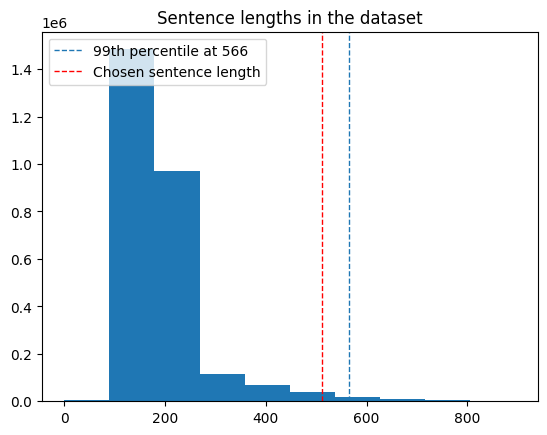

In [11]:
q99 = np.quantile(lengths, 0.99)
plt.hist(lengths, range = (0, max(sentence_length, np.quantile(lengths, 0.999)) + 50))
plt.axvline(q99, linestyle='--', linewidth=1, label=f"99th percentile at {q99:0.0f}")
plt.axvline(sentence_length - 1, linestyle='--', linewidth=1, label="Chosen sentence length", color = "red")
plt.title("Sentence lengths in the dataset")
plt.legend()
plt.show()

In [12]:
n_tokens = sum(lengths) # Each known word is a token.
print(f"The training dataset contains {n_tokens} tokens and {len(sentences)} sentences.")

The training dataset contains 530122021 tokens and 2717700 sentences.


In [13]:
def tokenize(text: str) -> tf.Tensor:
    indices = [vocab.get(word, UNK_ID) for word in text]
    return tf.constant([START_ID] + indices + [EOS_ID] \
    + [PAD_ID] * (sentence_length - len(indices) - 1), dtype = tf.int32)

def decode(input_ids: tf.Tensor) -> str:
    return " ".join([idx2word[int(idx)] for idx in input_ids if idx != PAD_ID])

# Tokenizing each sentence to build the model inputs. Padding and masking are deferred.
input_ids = tf.stack(list(map(tokenize, sentences)))
val_ids = tf.stack(list(map(tokenize, val_sentences)))
print(f"The first training example is: {decode(input_ids[0])}")

The first training example is: <S> once upon a time there was a little boy named ben . ben loved to explore the world around him . he saw many amazing things , like beautiful vases that were on display in a store . one day , ben was walking through the store when he came across a very special vase . when ben saw it he was amazed ! he said , wow , that is a really amazing vase ! can i buy it ? the shopkeeper smiled and said , of course you can . you can take it home and show all your friends how amazing it is ! so ben took the vase home and he was so proud of it ! he called his friends over and showed them the amazing vase . all his friends thought the vase was beautiful and couldn ' t believe how lucky ben was . and that ' s how ben found an amazing vase in the store ! <EOS>


### Creating batched TensorFlow datasets for TPU training.

In [14]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

def make_dataset(input_ids):
    dataset = tf.data.Dataset.from_tensor_slices(input_ids)
    dataset = dataset.map(
    lambda x: (x[:-1], x[1:]),
    num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.shuffle(len(input_ids))
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_set = make_dataset(input_ids)
val_set = make_dataset(val_ids)

## Model definition
### Reusable layers

In [15]:
class FeedForward(tf.keras.Model):
    def __init__(self, emb_dim, units):
        super().__init__()
        self.units = units
        self.dense1 = Dense(units, activation = "relu")
        self.dense2 = Dense(emb_dim)

    def build(self, input_shape):
        self.dense1.build(input_shape)
        self.dense2.build(input_shape[: - 1] + (self.units, ))
        super().build(input_shape)
        
    def call(self, x):
        x = self.dense1(x)
        out = self.dense2(x)
        return out

In [16]:
# Decoder block, n of it are stacked on top of each other in the Transformer.
class Decoder(tf.keras.Model):
    def __init__(self, n_heads = 8, emb_dim = 512, units = 2048, dropout = .1):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, emb_dim//n_heads)
        self.dropout1 =  Dropout(dropout)
        self.ln1 = LayerNormalization()
        
        self.ffn = FeedForward(emb_dim, units)
        self.dropout2 =  Dropout(dropout)
        self.ln2 = LayerNormalization()

    def build(self, input_shape):
        self.mha.build(input_shape, input_shape, input_shape)
        self.dropout1.build(input_shape)
        self.ln1.build(input_shape)
        self.ffn.build(input_shape)
        self.dropout2.build(input_shape)
        self.ln2.build(input_shape)

        super().build(input_shape)
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def call(self, x, training):
        # Masked multi-head self-attention
        # It's more convenient to mask the padding in the loss function.
        # The look-ahead mask is sufficient here.
        x1 = self.mha(x, x, x, use_causal_mask = True)
        x1 = self.dropout1(x1, training = training)
        x = self.ln1(x1 + x)
        
        x2 = self.ffn(x)
        x2 = self.dropout2(x2, training = training)
        x = self.ln2(x + x2)
        
        return x

### Transformer model class

In [17]:
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, sentence_length = 256, n = 6, n_heads = 8, emb_dim = 512, units = 2048, dropout = .1):
        super().__init__()
        self.emb_dim = emb_dim
        # Embedding layer
        self.embedding = Embedding(vocab_size, emb_dim, input_length = sentence_length)
        # Positional encoding
        self.pos_encode = Add()
        self.decoder_stack = [Decoder(n_heads, emb_dim, units, dropout) for _ in range(n)]

    def build(self, input_shape):
        self.embedding.build(input_shape)

        self.pos_encode.build([
           input_shape + (self.emb_dim, ),
           input_shape + (self.emb_dim, ),
        ])

        for decoder in self.decoder_stack:
            decoder.build(input_shape + (self.emb_dim, ))

        # # Final projection layer
        # self.linear.build(input_shape + (self.emb_dim, ))

        super().build(input_shape)

    def call(self, x, training = False):
        x = self.embedding(x)
        x = self.pos_encode([x, pos_encoding])
        
        for decoder in self.decoder_stack:
            x = decoder(x, training = training)

        # Weight tying the embeddings on either end of the model.
        out = tf.matmul(x, self.embedding.embeddings, transpose_b=True)
        
        return out

### Loss function

In [18]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits = True,
            reduction = tf.keras.losses.Reduction.NONE,
        )

    def call(self, y_true, y_pred):
        mask = y_true != PAD_ID
        y = tf.one_hot(tf.cast(y_true, tf.int32), vocab_size, axis = -1)[..., PAD_ID + 1:]
        y_pred = y_pred[..., PAD_ID + 1:]

        loss = self.loss(y, y_pred)
        mask = tf.cast(mask, loss.dtype)
        # Losses are then summed across replicas.
        return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)

### Model and optimizer hyperparameters 

In [19]:
class TransformerLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_steps, dtype=tf.float32):
        super(TransformerLearningRateSchedule, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.dtype = dtype
        self.warmup_steps = tf.cast(warmup_steps, self.dtype)

    def __call__(self, step):
        step = tf.cast(step, self.dtype)
        warmup_steps = tf.cast(self.warmup_steps, self.dtype)
        x1 = tf.math.pow(step, tf.constant(-0.5, dtype = self.dtype))
        x2 = step * tf.math.pow(self.warmup_steps, tf.constant(-1.5, dtype = self.dtype))
        return self.initial_learning_rate * tf.math.minimum(x1, x2)

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'warmup_steps': self.warmup_steps,
            'dtype': self.dtype
        }

In [20]:
# Model hyperparams.
emb_dim = 512
n_heads = 8
units = 2048
n = 6
dropout = 0.0

warmup_steps = 4000
learning_rate_schedule = TransformerLearningRateSchedule(emb_dim**-.5, warmup_steps)

In [21]:
# Positional encoding
pos_encoding = np.zeros((sentence_length, emb_dim))
pos = np.arange(sentence_length)[:, np.newaxis]
even = np.arange(emb_dim, step = 2)[np.newaxis, :]
pos_encoding[:, ::2] = np.sin(pos/10**(4*even/emb_dim))
pos_encoding[:, 1::2] = np.cos(pos/10**(4*even/emb_dim))
pos_encoding = pos_encoding[np.newaxis, :, :] # Adding the batch dimension
pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)

## Training

In [22]:
with strategy.scope():
    optimizer = AdamW(learning_rate_schedule)
    model = Transformer(vocab_size, sentence_length, n, n_heads, emb_dim, units, dropout)
    masked_loss = MaskedLoss(vocab_size)
    perplexity = Perplexity(from_logits = True, mask_token_id = PAD_ID)
    model.compile(optimizer, masked_loss, metrics = [perplexity])
    model.build((None, sentence_length))

model.summary()

/usr/local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 512, 512)       │    19,858,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 512, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ (None, 512, 512)       │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ (None, 512, 512)       │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ (None, 512, 512)       │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Decoder)             │ (None, 512, 512)       │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_4 (Decoder)             │ (None, 512, 512)       │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_5 (Decoder)             │ (None, 512, 512)       │     3,152,384 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,773,248 (147.91 MB)

 Trainable params: 38,773,248 (147.91 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
epochs = 5

history = model.fit(train_set, epochs = epochs, validation_data=val_set, verbose = 2)

Epoch 1/5


10616/10616 - 1425s - 134ms/step - loss: 2.4853 - perplexity: 12.0054 - val_loss: 1.6976 - val_perplexity: 5.4607


Epoch 2/5


10616/10616 - 1385s - 130ms/step - loss: 1.5959 - perplexity: 4.9330 - val_loss: 1.5263 - val_perplexity: 4.6013


Epoch 3/5


10616/10616 - 1421s - 134ms/step - loss: 1.4909 - perplexity: 4.4413 - val_loss: 1.4382 - val_perplexity: 4.2131


Epoch 4/5


10616/10616 - 1409s - 133ms/step - loss: 1.4191 - perplexity: 4.1334 - val_loss: 1.4013 - val_perplexity: 4.0607


Epoch 5/5


10616/10616 - 1402s - 132ms/step - loss: 1.3799 - perplexity: 3.9745 - val_loss: 1.3631 - val_perplexity: 3.9082


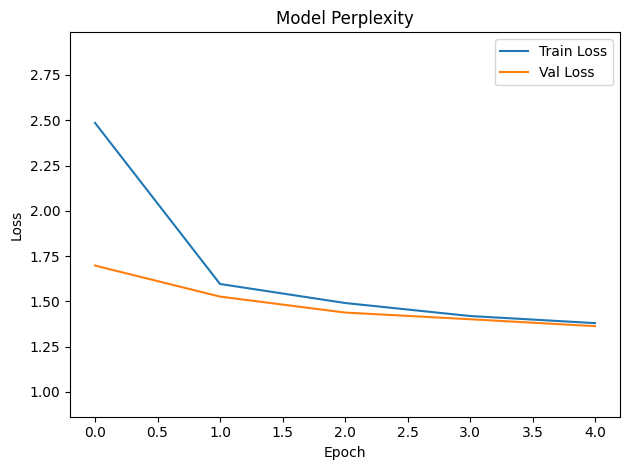

In [24]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim(min(history.history['loss'] + history.history['val_loss']) - 0.5,\
         max(history.history['loss'] + history.history['val_loss']) + 0.5)
plt.tight_layout()
plt.show()

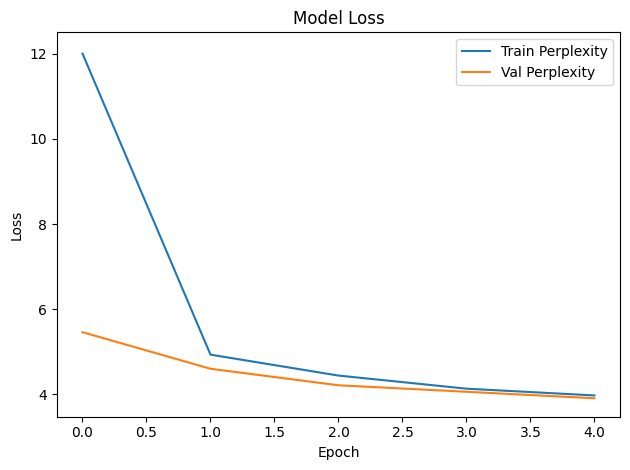

In [25]:
plt.plot(history.history['perplexity'], label='Train Perplexity')
plt.plot(history.history['val_perplexity'], label='Val Perplexity')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim(min(history.history['perplexity'] + history.history['perplexity']) - 0.5,\
         max(history.history['perplexity'] + history.history['perplexity']) + 0.5)
plt.tight_layout()
plt.show()

## Evaluation

In [26]:
# Examining the 1st example.
x, y = next(iter(val_set))
x, y = x[:1], y[:1]

logits = model(x)
am = tf.nn.softmax(logits - tf.reduce_max(logits, axis = -1, keepdims = True), axis = -1)
indices = list(map(int, x[0, 1:]))
am = tf.reshape(am, (-1, vocab_size))
probs = []

for i, idx in enumerate(indices[:20]):
    if idx == PAD_ID:
        break
    print(f"Token: \"{idx2word[idx]}\", Probability: {float(am[i, idx]):0.4f}.")
    probs.append(float(am[i, idx]))

Token: "once", Probability: 0.5935.
Token: "upon", Probability: 0.9500.
Token: "a", Probability: 0.9999.
Token: "time", Probability: 0.9997.
Token: ",", Probability: 0.9330.
Token: "there", Probability: 0.8323.
Token: "was", Probability: 0.9767.
Token: "a", Probability: 0.9849.
Token: "grumpy", Probability: 0.0025.
Token: "old", Probability: 0.0856.
Token: "man", Probability: 0.4364.
Token: ".", Probability: 0.4391.
Token: "he", Probability: 0.9718.
Token: "lived", Probability: 0.4090.
Token: "in", Probability: 0.9494.
Token: "a", Probability: 0.9760.
Token: "small", Probability: 0.7922.
Token: "house", Probability: 0.8627.
Token: ".", Probability: 0.1201.
Token: "one", Probability: 0.0328.


In [27]:
def softmax(logits, axis = -1):
    # Numerically stabilize logits by reducing the max to 0 (max exponent is now 1).
    logits = logits - np.max(logits, axis = axis, keepdims = True)
    e = np.exp(logits)
    return e / np.sum(e, axis = axis)

def format_decoded_text(s):
    splitted = re.split(r'([!?.])', s)
    splitted[::2] = [x.strip().capitalize() for x in splitted[::2]]
    splitted[1::2] = [x + " " for x in splitted[1::2]]
    return re.sub(r'\s*([,;:()\[\]{}"\'\-_|+\*/\\^@$`])\s*', r'\1 ', "".join(splitted))

def sample(n = 3, temperature = .7):
    print("Generated stories:")
    for _ in range(n):
        x = np.zeros((sentence_length + 1)) 
        # The first token is <S> which is irrelevant to the output.
        x[0] = START_ID
        i = 0
        choices = []
        choice = 0
        indices = list(range(vocab_size))
        
        while choice != EOS_ID and i < sentence_length:
            out = np.ravel(model(x[:-1].reshape(1, sentence_length))[0, i])
            # output shape is (batch_size, sentence_length, vocab_size)
            probs = softmax(out / temperature, axis = -1)
            choice = np.random.choice(indices, p = probs)
            i = i + 1
            x[i] = choice
            if choice != EOS_ID:
                choices.append(choice)
        
        res = format_decoded_text(" ".join(map(lambda x : idx2word[x], choices)))
        print(f"{res}\n")
        

sample(3)

Generated stories:


Once upon a time, there was a little girl named sue. Sue had a red ball that she loved to play with. One day, sue' s mom decided to teach her about a new boy. Her name was tom. Tom was very good at games. Tom was a spoiled boy. He always wanted to play with sue' s red ball. One day, tom' s mom taught tom how to take care of his toys. Tom said, " sue, can you teach me how to play with your friends?" sue was happy to help. She told tom, " i will teach you how to play with my toys." tom was excited. He played with his red ball all day. He learned how to be a better friend. Sue was happy to learn about tom' s words. She knew that her toys were safe and fun to play with. 



Once upon a time, there was a little girl named lily. She had a big, red ball. Lily loved to play with her ball all day. She would throw it, kick it, and roll it all day long. One day, lily saw a small, hurt bird on the ground. The bird looked sad and had no place to play. Lily wanted to help the bird, so she picked up the bird and took it to her house. Lily' s mom saw the hurt bird and said, " don' t worry, we can help you." they took the bird to the doctor. The doctor put a bandage on it and gave it some medicine. The bird got better and started to play with lily. Lily was very happy that she could help her new friend. The bird flew away, and lily knew she had done a good thing. 



One day, a little bird named tim was flying in the sky. He saw a big tree with a nest. Tim wanted to look inside the nest. He thought it was a good place to rest. Tim flew down and sat on a branch. He saw a serious squirrel named sam. Sam was sad because he lost his nut. Tim wanted to help sam. He said, " i will help you find your nut." they looked for the nut together. They looked under the tree, behind the rock, and in the dirt. But they could not find the nut. Then, something unexpected happened. A big bird came down from the sky. The big bird said, " i saw your nut." tim was happy. He said, " thank you!" now, tim and sam were friends and played together all day. 

